In [2]:
import sys
sys.path.append('/home1/dscho/code/projects/manning_replication')
import os
import glob
import pickle
from time import time
from time import strftime
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
from collections import OrderedDict
from importlib import reload

import numpy as np
import pandas as pd
#import xarray as xr
import scipy.io as sio
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
import scipy.signal as signal
import statsmodels.api as sm
 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
#from mpl_toolkits.mplot3d import Axes3D
#import plotly.plotly as py
#import plotly.graph_objs as go
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'medium'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
from cluster_helper.cluster import cluster_view
from ptsa.data.TimeSeriesX import TimeSeries 
#from ptsa.data.filters import MorletWaveletFilter
#from ptsa.data.filters import ButterworthFilter
#from ptsa.data.filters import MonopolarToBipolarMapper
import manning_utils
import manning_analysis
from eeg_plotting import plot_trace

In [11]:
## Setup project.
dirs, subj_info, config, subj_df, subj_df_file = manning_analysis.setup_session()
data_dir = dirs['data']
epoch_dir = os.path.join(data_dir, 'epoch')
figure_dir = dirs['figs']
sessions = subj_df.groupby('subj_sess').mean().index.tolist()#

Loading subjects DataFrame: /data3/scratch/dscho/frLfp/data/subj_df.xlsx

There are 20 subjects, 46 sessions, and 2944 channels in the study.

46 sessions will be processed: ['U367_env2', 'U369_env1', 'U369_env2', 'U370_env1', 'U371_env1', 'U371_env2', 'U371_env3', 'U372_ses1', 'U372_ses2', 'U373_ses1', 'U373_ses2', 'U373_ses3', 'U374_ses1', 'U374_ses2', 'U379_ses1', 'U380_ses1a', 'U380_ses2', 'U380_ses3', 'U381_ses1', 'U381_ses2', 'U381_ses3', 'U384_ses1', 'U384_ses2', 'U384_ses3', 'U385_ses1', 'U385_ses2', 'U385_ses3', 'U385_ses4', 'U386_ses1', 'U386_ses2', 'U387_ses1', 'U387_ses2', 'U387_ses3', 'U390_ses1', 'U390_ses2', 'U390_ses3', 'U390_ses4', 'U392_ses1', 'U393_ses2', 'U394_ses1', 'U394_ses3', 'U395_ses1', 'U395_ses2', 'U395_ses3', 'U396_ses2', 'U396_ses3']
0 sessions have missing input files and will not be processed.



In [16]:
# Load all epoch data and get channel/cluster mappings.
epoch_dat = {}
for subj_sess in sessions:
    fr_file = os.path.join(epoch_dir, '{}_fr_epoch-2Hz-cut3.hdf'.format(subj_sess))
    power_file = os.path.join(epoch_dir, '{}_power_width5_2-200Hz-50log10steps_epoch-2Hz-cut3_log10_Z-acrossfreq.hdf'.format(subj_sess))
    bands_file = os.path.join(epoch_dir, '{}_power_width5_2-200Hz-50log10steps_epoch-2Hz-cut3_log10_Z-acrossfreq_freqbands.hdf'.format(subj_sess))
    files_exist = (os.path.exists(fr_file) and os.path.exists(power_file) and os.path.exists(bands_file))
    if files_exist:
        epoch_dat[subj_sess] = {'fr': TimeSeries.from_hdf(fr_file),
                                'power': TimeSeries.from_hdf(power_file),
                                'bands': TimeSeries.from_hdf(bands_file)}
sessions = list(epoch_dat.keys())
print('Loaded epoch data for {} sessions.'.format(len(epoch_dat)))

Loaded epoch data for 10 sessions.


In [17]:
n_units = 0
for subj_sess in sessions:
    print('{}: {} units, {} epochs, {} channels.'.format(subj_sess, 
                                                         epoch_dat[subj_sess]['fr'].shape[0],
                                                         epoch_dat[subj_sess]['fr'].shape[1],
                                                         epoch_dat[subj_sess]['power'].shape[0]))
    n_units += epoch_dat[subj_sess]['fr'].shape[0]
print('{} units in total.'.format(n_units))

U367_env2: 73 units, 2983 epochs, 64 channels.
U369_env2: 41 units, 1645 epochs, 64 channels.
U379_ses1: 80 units, 2237 epochs, 64 channels.
U380_ses1a: 65 units, 2544 epochs, 64 channels.
U381_ses1: 49 units, 3265 epochs, 64 channels.
U384_ses3: 59 units, 1692 epochs, 64 channels.
U390_ses1: 15 units, 2889 epochs, 64 channels.
U394_ses3: 23 units, 1814 epochs, 64 channels.
U395_ses2: 32 units, 3206 epochs, 64 channels.
U395_ses3: 25 units, 3074 epochs, 64 channels.
462 units in total.


In [18]:
# Load session metadata.
files = []
for subj_sess in sessions:
    f = os.path.join(data_dir, 'metadata', 'subj_df_{}.xlsx'.format(subj_sess))
    assert os.path.exists(f)
    files.append(f)
    
subj_df = pd.read_excel(files[0], converters={'chan': str})
for f in files[1:]:
    subj_df = subj_df.append(pd.read_excel(f, converters={'chan': str}))

In [403]:
# For each subject, for each unit, ignore the top 1% of firing rate epochs
# and then divide the remaining epochs into quintiles based on firing rate.

# fr_quintiles[subj_sess][cluster_number] is a 5-length list
# where the first element will contain the epoch indices of
# the first quintile of firing rates, the second element with
# contain the epoch indices of the second quintile of firing
# rates, etc.
fr_quintiles = OrderedDict()
for subj_sess in sessions:
    fr_quintiles[subj_sess] = OrderedDict()
    fr = epoch_dat[subj_sess]['fr'].copy()
    fr_sort = fr.argsort(axis=1).data
    n_clus = len(fr.cluster)
    n_epochs = len(fr.epoch)
    cut20 = int(round(0.2 * int(n_epochs * 0.99), 0))
    cut40 = int(round(0.4 * int(n_epochs * 0.99), 0))
    cut60 = int(round(0.6 * int(n_epochs * 0.99), 0))
    cut80 = int(round(0.8 * int(n_epochs * 0.99), 0))
    cut100 = int(round(1. * int(n_epochs * 0.99), 0))
    for i in range(n_clus):
        fr_quintiles[subj_sess][i] = [fr_sort[i, :cut20],
                                      fr_sort[i, cut20:cut40],
                                      fr_sort[i, cut40:cut60],
                                      fr_sort[i, cut60:cut80],
                                      fr_sort[i, cut80:cut100]]

In [97]:
cut20, cut40, cut60, cut80, cut100, n_epochs

(591, 1181, 1772, 2362, 2953, 2983)

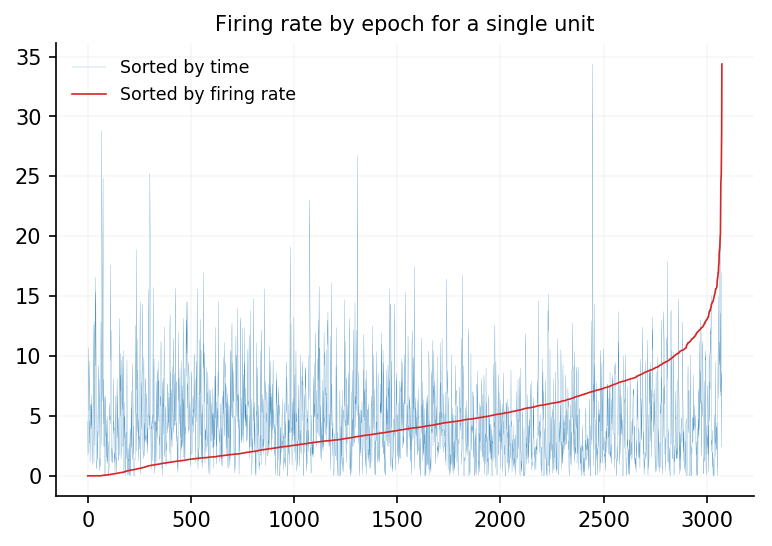

In [404]:
fr.data.shape, fr_sort.data.shape
i = 0
plt.plot(fr.data[i, :], linewidth=0.1, label='Sorted by time')
plt.plot(fr.data[i, :][fr_sort[i, :]], label='Sorted by firing rate')
plt.legend()
plt.title('Firing rate by epoch for a single unit')

f = os.path.join(figure_dir, 'firing_rate_by_epoch_for_a_single_unit.png')
#fig.savefig(f)

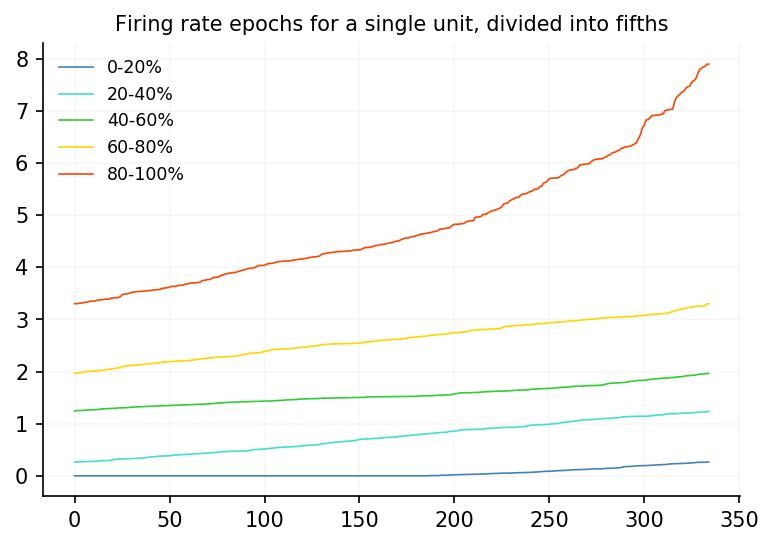

In [406]:
# Then calculate the mean +/- SEM of power at each frequency for each quintile
# across units, and plot. Analogous to Manning Fig 7.
subj_sess = sessions[5]
clus = 10
colors = ['steelblue', 'turquoise', 'limegreen', 'gold', 'orangered']
labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
for i in range(5):
    plt.plot(epoch_dat[subj_sess]['fr'][clus, fr_quintiles[subj_sess][clus][i]], label=labels[i], color=colors[i])
plt.legend()
plt.title('Firing rate epochs for a single unit, divided into fifths')

f = os.path.join(figure_dir, 'firing_rate_by_epoch_for_a_single_unit.png')
#fig.savefig(f)

In [204]:
subj_sess = sessions[0]
fr = epoch_dat[subj_sess]['fr'].copy()
power = epoch_dat[subj_sess]['power'].copy()
clus_to_chan = OrderedDict(zip(fr.cluster.data, fr.channel))
clus = 0
chan = clus_to_chan[clus]
quintile = 0
print(subj_sess, clus, chan, quintile)

U367_env2 0 1 0


In [398]:
# subj_sess = 'U367_env2'
# power_quintiles[subj_sess] = OrderedDict()
# fr = epoch_dat[subj_sess]['fr'].copy()
# power = epoch_dat[subj_sess]['power'].copy()
# clus_to_chan = OrderedDict(zip(fr.cluster.data, fr.channel))
# clus_to_chan

In [216]:
# Then calculate the mean +/- SEM of power at each frequency for each quintile
# across units, and plot. Analogous to Manning Fig 7.

# power_quintiles[subj_sess][quintile] contains an n_units x n_frequencies
# array of power values, where the first quintile has the mean power during
# epochs that fell within the first quintile of firing rate for a given unit,
# etc.
power_quintiles = OrderedDict()
for subj_sess in sessions:
    power_quintiles[subj_sess] = OrderedDict()
    fr = epoch_dat[subj_sess]['fr'].copy()
    power = epoch_dat[subj_sess]['power'].copy()
    clus_to_chan = OrderedDict(zip(fr.cluster.data, fr.channel))
    n_clus = len(fr.cluster)
    n_epochs = len(fr.epoch)
    for quintile in range(5):
        q = 'q{}'.format(quintile+1)
        power_quintiles[subj_sess][q] = []
        for clus in range(n_clus):
            chan = clus_to_chan[clus]
            epochs = fr_quintiles[subj_sess][clus][quintile]
            power_quintiles[subj_sess][q].append(power.sel(channel=chan, epoch=epochs).mean('epoch').data)
        power_quintiles[subj_sess][q] = np.array(power_quintiles[subj_sess][q])
        
power_quintiles_all = OrderedDict()
for quintile in range(5):
    q = 'q{}'.format(quintile+1)
    power_quintiles_all[q] = power_quintiles[sessions[0]][q]
    for subj_sess in sessions[1:]:
        power_quintiles_all[q] = np.vstack((power_quintiles_all[q], power_quintiles[subj_sess][q]))

[Text(0,0,'2'),
 Text(0,0,'4'),
 Text(0,0,'8'),
 Text(0,0,'16'),
 Text(0,0,'32'),
 Text(0,0,'64'),
 Text(0,0,'128')]

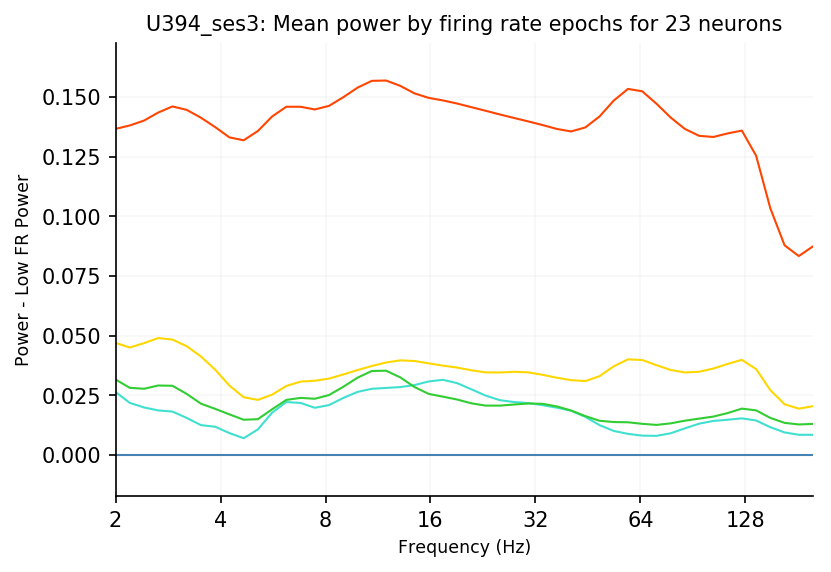

In [339]:
subj_sess = sessions[7]
xaxis = np.log10(epoch_dat[sessions[0]]['power'].freq.data)
colors = ['steelblue', 'turquoise', 'limegreen', 'gold', 'orangered']
n_units = power_quintiles[subj_sess]['q1'].shape[0]

dat = np.vstack((np.mean(power_quintiles[subj_sess]['q1'], axis=0) - np.mean(power_quintiles[subj_sess]['q1'], axis=0),
                 np.mean(power_quintiles[subj_sess]['q2'], axis=0) - np.mean(power_quintiles[subj_sess]['q1'], axis=0),
                 np.mean(power_quintiles[subj_sess]['q3'], axis=0) - np.mean(power_quintiles[subj_sess]['q1'], axis=0),
                 np.mean(power_quintiles[subj_sess]['q4'], axis=0) - np.mean(power_quintiles[subj_sess]['q1'], axis=0),
                 np.mean(power_quintiles[subj_sess]['q5'], axis=0) - np.mean(power_quintiles[subj_sess]['q1'], axis=0)))

fig, ax = plot_trace(dat, 
                     x_units='samples', 
                     x_inds=xaxis,
                     x_lab='Frequency (Hz)',
                     y_lab='Power - Low FR Power',
                     linewidths=[1]*5, 
                     colors=colors,
                     figsize=[6, 4], 
                     title='{}: Mean power by firing rate epochs for {} neurons'.format(subj_sess, n_units))

ax[0].set_xticks(np.log10([2, 4, 8, 16, 32, 64, 128]))
ax[0].set_xticklabels([2, 4, 8, 16, 32, 64, 128])

[Text(0,0,'2'),
 Text(0,0,'4'),
 Text(0,0,'8'),
 Text(0,0,'16'),
 Text(0,0,'32'),
 Text(0,0,'64'),
 Text(0,0,'128')]

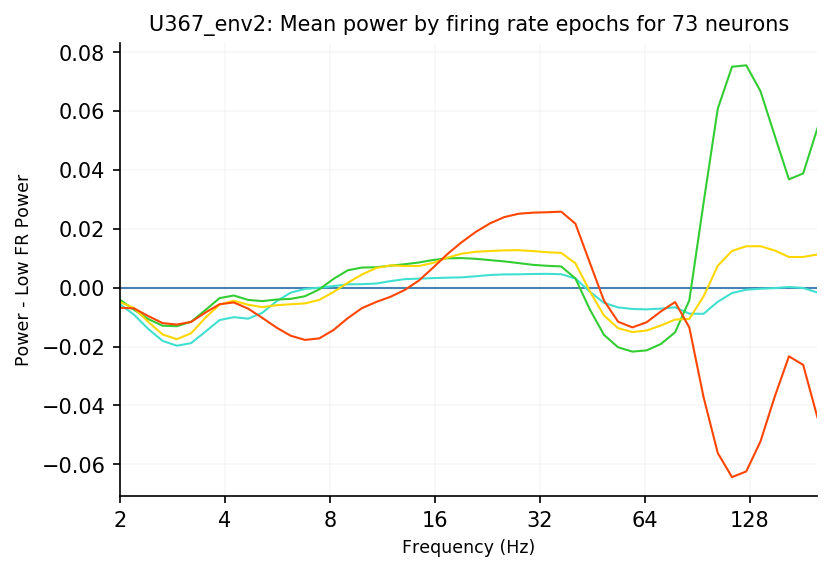

In [338]:
subj_sess = sessions[0]
xaxis = np.log10(epoch_dat[sessions[0]]['power'].freq.data)
colors = ['steelblue', 'turquoise', 'limegreen', 'gold', 'orangered']
n_units = power_quintiles[subj_sess]['q1'].shape[0]

dat = np.vstack((np.mean(power_quintiles[subj_sess]['q1'], axis=0) - np.mean(power_quintiles[subj_sess]['q1'], axis=0),
                 np.mean(power_quintiles[subj_sess]['q2'], axis=0) - np.mean(power_quintiles[subj_sess]['q1'], axis=0),
                 np.mean(power_quintiles[subj_sess]['q3'], axis=0) - np.mean(power_quintiles[subj_sess]['q1'], axis=0),
                 np.mean(power_quintiles[subj_sess]['q4'], axis=0) - np.mean(power_quintiles[subj_sess]['q1'], axis=0),
                 np.mean(power_quintiles[subj_sess]['q5'], axis=0) - np.mean(power_quintiles[subj_sess]['q1'], axis=0)))

fig, ax = plot_trace(dat, 
                     x_units='samples', 
                     x_inds=xaxis,
                     x_lab='Frequency (Hz)',
                     y_lab='Power - Low FR Power',
                     linewidths=[1]*5, 
                     colors=colors,
                     figsize=[6, 4], 
                     title='{}: Mean power by firing rate epochs for {} neurons'.format(subj_sess, n_units))

ax[0].set_xticks(np.log10([2, 4, 8, 16, 32, 64, 128]))
ax[0].set_xticklabels([2, 4, 8, 16, 32, 64, 128])

[Text(0,0,'2'),
 Text(0,0,'4'),
 Text(0,0,'8'),
 Text(0,0,'16'),
 Text(0,0,'32'),
 Text(0,0,'64'),
 Text(0,0,'128')]

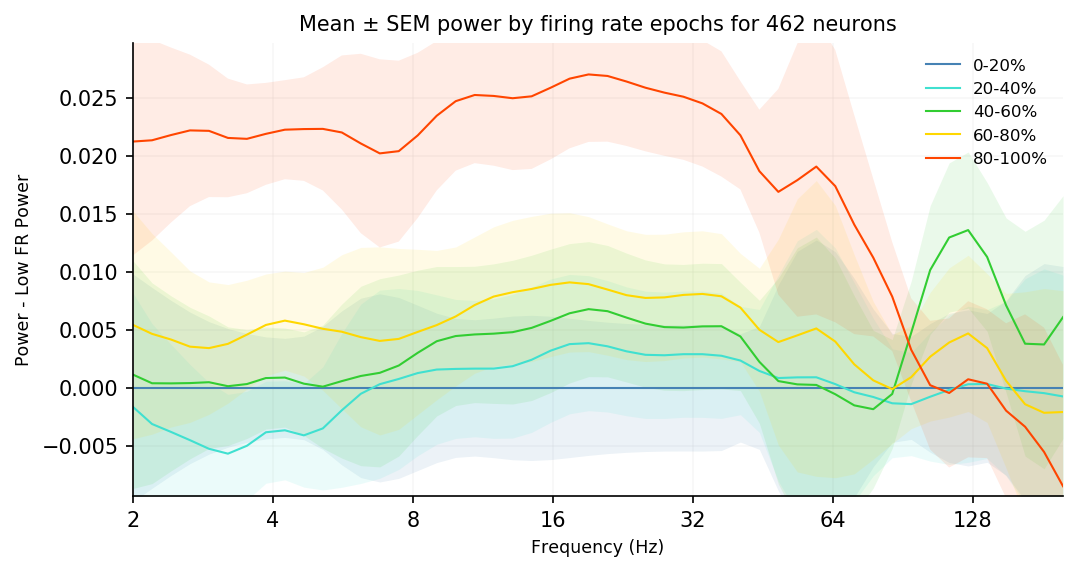

In [392]:
xaxis = np.log10(epoch_dat[sessions[0]]['power'].freq.data)
colors = ['steelblue', 'turquoise', 'limegreen', 'gold', 'orangered']

d = np.array([power_quintiles_all['q1'] - np.mean(power_quintiles_all['q1'], axis=0),
              power_quintiles_all['q2'] - np.mean(power_quintiles_all['q1'], axis=0),
              power_quintiles_all['q3'] - np.mean(power_quintiles_all['q1'], axis=0),
              power_quintiles_all['q4'] - np.mean(power_quintiles_all['q1'], axis=0),
              power_quintiles_all['q5'] - np.mean(power_quintiles_all['q1'], axis=0)])

dat = np.vstack((np.mean(power_quintiles_all['q1'] - np.mean(power_quintiles_all['q1'], axis=0), axis=0),
                 np.mean(power_quintiles_all['q2'] - np.mean(power_quintiles_all['q1'], axis=0), axis=0),
                 np.mean(power_quintiles_all['q3'] - np.mean(power_quintiles_all['q1'], axis=0), axis=0),
                 np.mean(power_quintiles_all['q4'] - np.mean(power_quintiles_all['q1'], axis=0), axis=0),
                 np.mean(power_quintiles_all['q5'] - np.mean(power_quintiles_all['q1'], axis=0), axis=0)))

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax = np.ravel(ax)

for i in range(5):
    q = 'q{}'.format(i+1)
    ax[0].fill_between(xaxis, 
                       np.mean(d[i,:,:], axis=0) - stats.sem(d[0,:,:], axis=0),
                       np.mean(d[i,:,:], axis=0) + stats.sem(d[0,:,:], axis=0),
                       color=colors[i], alpha=0.1, linewidth=0)
    
plot_trace(dat, 
           x_units='samples', 
           x_inds=xaxis,
           x_lab='Frequency (Hz)',
           y_lab='Power - Low FR Power',
           linewidths=[1]*5, 
           colors=colors,
           legend_labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'],
           title='Mean ± SEM power by firing rate epochs for {} neurons'.format(power_quintiles_all['q1'].shape[0]),
           figsize=[6, 4],
           fig=fig, 
           ax=ax)

ax[0].set_xticks(np.log10([2, 4, 8, 16, 32, 64, 128]))
ax[0].set_xticklabels([2, 4, 8, 16, 32, 64, 128])

In [ ]:
# frequency x firing rate x power

In [393]:
power_quintiles['U367_env2']['q1']

array([[ 1.5928627 ,  1.52047862,  1.44207612, ..., -1.48062756,
        -1.52816752, -1.5727349 ],
       [ 1.583532  ,  1.51084812,  1.439623  , ..., -1.47725015,
        -1.52494521, -1.56939069],
       [ 1.3930451 ,  1.35462108,  1.31589836, ..., -1.45875975,
        -1.51668297, -1.52324859],
       ...,
       [ 1.64772982,  1.60618599,  1.5509493 , ..., -1.74534815,
        -1.80909837, -1.78738813],
       [ 1.62538761,  1.57888745,  1.53674026, ..., -1.92099714,
        -1.99396207, -2.04947249],
       [ 1.64320084,  1.60203683,  1.55153771, ..., -1.92399929,
        -1.99666486, -2.05199791]])

In [149]:
epoch_dat[subj_sess]['bands'].sel(freq='bband_power')

<xarray.TimeSeries 'U384_ses3' (channel: 64, epoch: 1692)>
array([[-0.036392, -0.14468 , -0.143521, ...,  0.025074,  0.009351, -0.04418 ],
       [ 0.005481, -0.139106, -0.177079, ...,  0.069988,  0.029739, -0.041103],
       [-0.06037 , -0.190218, -0.112811, ...,  0.050234,  0.054812, -0.000932],
       ...,
       [ 0.099517,  0.027836, -0.018268, ...,  0.015492, -0.004379, -0.125166],
       [-0.097683, -0.038595, -0.118222, ..., -0.015742,  0.03284 ,  0.089288],
       [-0.020085, -0.148785, -0.07213 , ...,  0.001726, -0.071531, -0.009867]])
Coordinates:
  * channel     (channel) <U2 '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' ...
  * epoch       (epoch) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    freq        <U11 'bband_power'
    samplerate  float64 2.0
Attributes:
    epoch_bins:   [[3000, 4000], [4000, 5000], [5000, 6000], [6000, 7000], [7...
    process_tag:  power_width5_2-200Hz-50log10steps_epoch-2Hz-cut3_log10_Z-ac...

In [49]:
# np.argsort example.
x = np.random.randint(0, 100, 20)
xsort = np.argsort(x)

print(x)
print(xsort)
print(x[xsort[:5]], x[xsort[5:10]], x[xsort[10:15]], x[xsort[15:]])

[ 5 64 69 27 21 74 97 68 70 56 74 31 95 74 36 66 66 95 24 24]
[ 0  4 18 19  3 11 14  9  1 15 16  7  2  8  5 10 13 12 17  6]
[ 5 21 24 24 27] [31 36 56 64 66] [66 68 69 70 74] [74 74 95 95 97]


In [ ]:
#clus = 6

for clus in range(epoch_fr.shape[0]):
    plt.close('all')
    fr_order = np.argsort(epoch_fr[clus, :]).data
    fr_order = fr_order[:int(len(fr_order) * 0.99)] # remove epochs in the top 1% of firing rates
    cut25 = int(round(len(fr_order) * 0.25, 0))
    cut50 = int(round(len(fr_order) * 0.50, 0))
    cut75 = int(round(len(fr_order) * 0.75, 0))
    fr_bins = [fr_order[:cut25], fr_order[cut25:cut50], fr_order[cut50:cut75], fr_order[cut75:]]
    epoch_dat = epoch_power.copy().sel(channel=clus_to_chan[clus]).data
    dat = np.vstack((np.mean(epoch_dat[fr_bins[0], :], axis=0),
                     np.mean(epoch_dat[fr_bins[1], :], axis=0),
                     np.mean(epoch_dat[fr_bins[2], :], axis=0),
                     np.mean(epoch_dat[fr_bins[3], :], axis=0)))

    colors = ['C0', 'C2', 'Gold', 'C1']
    fig, ax = plot_trace(dat, x_units='samples', x_inds=np.log10(freqs),
                         linewidths=[0]*4, colors=colors,
                         figsize=[6, 4], 
                         title=('{}: Channel {}, Neuron {} ({})'
                                .format(subj_sess, clus_to_chan[clus], clus, 
                                        fr_df.loc[fr_df.clus==clus, 'location'].iat[0])))
    legend_labels = {0: '0-25%', 1: '25-50%', 2: '50-75%', 3: '75-100%'}
    for i in range(4):
        ax[0].fill_between(np.log10(freqs), 
                           (np.mean(epoch_dat[fr_bins[i], :], axis=0) 
                            - stats.sem(epoch_dat[fr_bins[i], :], axis=0)),
                           (np.mean(epoch_dat[fr_bins[i], :], axis=0) 
                            + stats.sem(epoch_dat[fr_bins[i], :], axis=0)),
                           color=colors[i], alpha=1, linewidth=0, label=legend_labels[i])
    ax[0].legend(loc=1, prop={'size': 6}, edgecolor='w')
    # ax[0].set_xticks(np.log10([2, 15, 150]))
    # ax[0].set_xticklabels([2, 15, 150])
    ax[0].set_xticks(np.log10([2, 4, 8, 16, 32, 64, 128]))
    ax[0].set_xticklabels([2, 4, 8, 16, 32, 64, 128])
    ax[0].set_yticks([-1, 0, 1])
    ax[0].set_ylim([-1.66, 1.66])
    ax[0].set_xlabel('Frequency (Hz)')
    ax[0].set_ylabel('Normalized Power')
    fig.tight_layout(h_pad=1, w_pad=1)

    f = os.path.join(figure_dir, 'power_by_fr_{}_chan{}_neuron{}_{}.png'
                     .format(subj_sess, chan, clus, fr_df.loc[fr_df.clus==clus, 'location'].iat[0]))
    fig.savefig(f)

(<Figure size 1800x600 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2acef70570b8>],
       dtype=object))

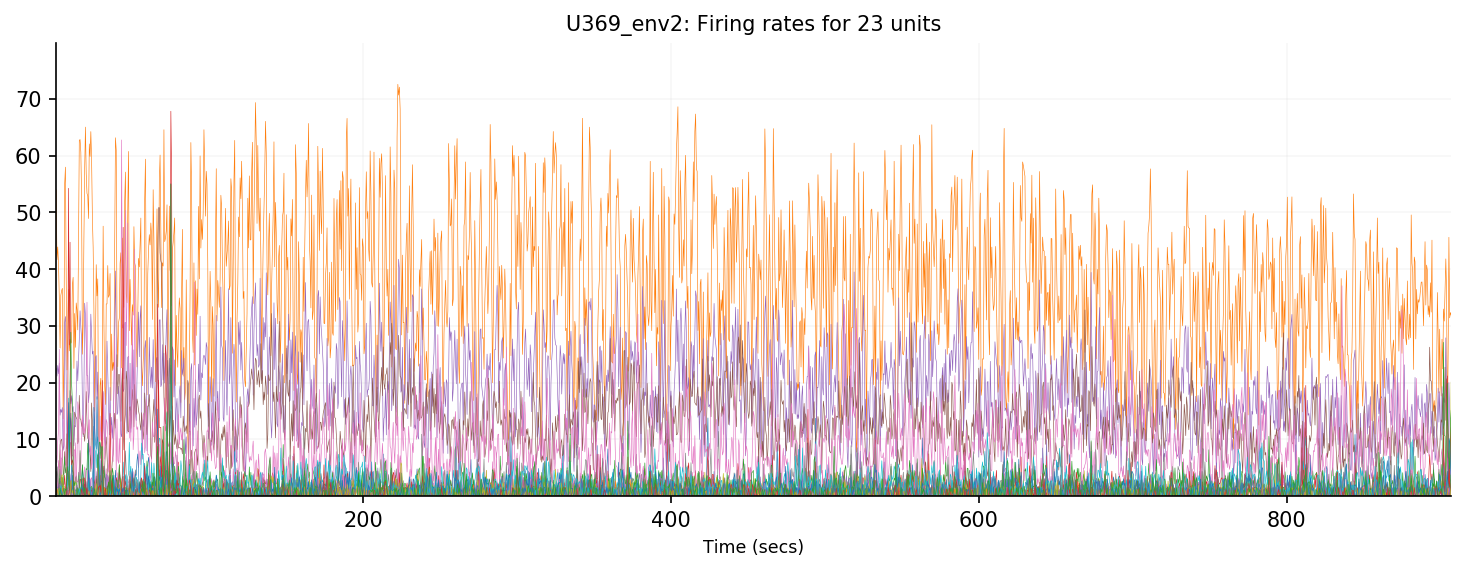

In [39]:
i = 7
plot_trace(epoch_dat[sessions[i]]['fr'], x_units='secs', sampling_rate=2, 
           title='{}: Firing rates for {} units'.format(epoch_dat[sessions[1]]['fr'].name, epoch_dat[sessions[i]]['fr'].shape[0]))

In [35]:
files = []
for subj_sess in sorted(epoch_dat.keys()):
    f = os.path.join(data_dir, 'spikes', '{}_session_spikes.pkl'.format(subj_sess))
    assert os.path.exists(f)
    files.append(f)

with open(files[2], 'rb') as f:
    spikes = pickle.load(f)

TypeError: file must have 'read' and 'readline' attributes

## Work to rerun preprocessing.

In [6]:
def epoch_sessions_parallel(subj_sess):
    """Wrapper function to process LFP and spike data through epoching."""
    import os
    import sys
    sys.path.append('/home1/dscho/code/projects/manning_replication')
    from time import strftime
    import logging
    import numpy as np
    import pandas as pd
    import manning_analysis
    
    # Read the subjects' DataFrame.
    subj_df_file = '/data3/scratch/dscho/frLfp/data/subj_df.xlsx'
    subj_df = pd.read_excel(subj_df_file)
    
    # Select frequencies to get power and phase estimates for.
    freq_low = 2
    freq_high = 200
    freq_steps = 50
    
    # Get processed LFP and spike data.
    subj_df_, lfp_raw, lfp_proc, session_spikes, fr_df, clus_to_chan, chan_to_clus = manning_analysis.preprocess_session(
                subj_sess, subj_df, subj_df_file, overwrite=False
            )
    
    # Epoch each channel.
    epoch_fr, epoch_power, epoch_band_power = manning_analysis.epoch_fr_power(
        subj_sess, 
        lfp_proc, 
        fr_df, 
        chan_to_clus, 
        chans=lfp_proc.channel.data,
        log_power=True,
        z_power='acrossfreq',
        freq_params={'low': freq_low, 'high': freq_high, 'num': freq_steps},
        epoch_size=1000,
        epoch_cut=3,
        power_file_suffix='_width5_{}-{}Hz-{}log10steps'.format(freq_low, freq_high, freq_steps),
        load_existing=True,
        save_files=True
    )
    
    return None

In [4]:
# Figure out which subjects have power files saved in ~data/lfp/morlet
files = glob.glob(os.path.join(data_dir, 'lfp', 'morlet', '*.hdf'))
power_files = OrderedDict()
for f in files:
    subj_sess = os.path.basename(f)[:os.path.basename(f).index('_ch')]
    if subj_sess not in power_files:
        power_files[subj_sess] = {'n_files': 1, 'files': [f]}
    else:
        power_files[subj_sess]['n_files'] += 1
        power_files[subj_sess]['files'].append(f)

In [322]:
# Run epoching in parallel.
print('Running preprocessing for {} sessions.'.format(len(sessions)))
print('Starting clusters.')
sessions = sorted(power_files.keys())
sessions = sessions[1:]
with cluster_view(scheduler="sge", queue="RAM.q", num_jobs=len(sessions), 
                  cores_per_job=1, extra_params={'mem':32}) as view: 
    output = view.map(epoch_sessions_parallel, sessions)

In [ ]:
# Run epoching in sequence.
sessions = sorted(power_files.keys())
start = time()

# Select frequencies to get power and phase estimates for.
freq_low = 2
freq_high = 200
freq_steps = 50
    
for subj_sess in sessions:
    # Get processed LFP and spike data.
    subj_df_, lfp_raw, lfp_proc, session_spikes, fr_df, clus_to_chan, chan_to_clus = manning_analysis.preprocess_session(
                subj_sess, subj_df, subj_df_file, overwrite=False
            )
    
    # Epoch each channel.
    logging.info('Starting manning_analysis.epoch_fr_power()')
    epoch_fr, epoch_power, epoch_band_power = manning_analysis.epoch_fr_power(
        subj_sess, 
        lfp_proc, 
        fr_df, 
        chan_to_clus, 
        chans=lfp_proc.channel.data,
        log_power=True,
        z_power='acrossfreq',
        freq_params={'low': freq_low, 'high': freq_high, 'num': freq_steps},
        epoch_size=1000,
        epoch_cut=3,
        power_file_suffix='_width5_{}-{}Hz-{}log10steps'.format(freq_low, freq_high, freq_steps),
        load_existing=True,
        save_files=True
    )
    print('{:.0f} secs'.format(time() - start))

INFO:preprocess_session:Loading subj_df, raw LFP, processed LFP, and spike data for U367_env2.

INFO:root:Starting manning_analysis.epoch_fr_power()
INFO:epoch_fr_power:Processing spike and power data into epochs.
INFO:epoch_fr_power:Loading power data for U367_env2 channel 1.
INFO:epoch_fr_power:Log transforming epoched power values.
INFO:epoch_fr_power:Z-scoring epoched power values across frequencies.
INFO:epoch_fr_power:Loading power data for U367_env2 channel 9.
INFO:epoch_fr_power:Loading power data for U367_env2 channel 17.
INFO:epoch_fr_power:Loading power data for U367_env2 channel 25.
INFO:epoch_fr_power:Loading power data for U367_env2 channel 33.
INFO:epoch_fr_power:Loading power data for U367_env2 channel 41.
INFO:epoch_fr_power:Loading power data for U367_env2 channel 49.
INFO:epoch_fr_power:Loading power data for U367_env2 channel 57.
INFO:epoch_fr_power:Saved epoched data to files:
	/data3/scratch/dscho/frLfp/data/epoch/U367_env2_fr_epoch-2Hz-cut3.hdf
	/data3/scratch/ds

1597 secs


INFO:root:Starting manning_analysis.epoch_fr_power()
INFO:epoch_fr_power:Processing spike and power data into epochs.
INFO:epoch_fr_power:Loading power data for U369_env2 channel 1.
INFO:epoch_fr_power:Log transforming epoched power values.
INFO:epoch_fr_power:Z-scoring epoched power values across frequencies.
INFO:epoch_fr_power:Loading power data for U369_env2 channel 9.
INFO:epoch_fr_power:Loading power data for U369_env2 channel 17.
INFO:epoch_fr_power:Loading power data for U369_env2 channel 25.
INFO:epoch_fr_power:Loading power data for U369_env2 channel 33.


In [226]:
# Remove power files for sessions with <64 files.
n_removed = 0
for subj_sess in power_files.keys():
    if power_files[subj_sess]['n_files'] < 64:
        for f in power_files[subj_sess]['files']:
            os.remove(f)
            n_removed += 1
print('Deleted {} files.'.format(n_removed))

Deleted 365 files.


## Epoch power

In [421]:
files = glob.glob(os.path.join(data_dir, 'lfp', 'morlet', '*power_width5_2-200Hz-50log10steps.hdf'))
power_files = OrderedDict()
for f in sorted(files):
    fname = os.path.basename(f).split('_')
    subj_sess = '{}_{}'.format(fname[0], fname[1])
    chan = fname[2][2:]
    power_files.setdefault(subj_sess, []).append(chan)

In [433]:
# Get the mean raw power at each frequency across time,
# within each epoch. Save epoch files, then delete the giant
# 2000Hz power files.
epoch_rates = [10, 2, 1, 0.5, 0.2]

start_time = time()
for subj_sess in sorted(power_files.keys()):
    for chan in power_files[subj_sess]:
        # Load the input power file.
        powerf = os.path.join(data_dir, 'lfp', 'morlet', '{}_ch{}_power_width5_2-200Hz-50log10steps.hdf'.format(subj_sess, chan))
        power = TimeSeries.from_hdf(powerf).squeeze() # frequency x time
        powerdat = power.data
        n_timepoints = len(power.time)
        sampling_rate = float(power.samplerate)
        
        for epoch_rate in epoch_rates:
            cut = int(np.ceil((sampling_rate*1.5) / (sampling_rate/epoch_rate)))

            # Get time bins, cutting the first and last 1.5secs of data.
            time_bins = manning_utils.get_epochs(np.arange(n_timepoints), epoch_size=(sampling_rate/epoch_rate), cut=cut)

            # Epoch the power data.
            epower = []
            for start, stop in time_bins:
                epower.append(np.mean(powerdat[:, start:stop], axis=1))
            epower = TimeSeries(np.array(epower), name=power.name, 
                                dims=['epoch', 'frequency'],
                                coords={'epoch': np.arange(len(time_bins)), 
                                        'frequency': power.frequency.data,
                                        'samplerate': epoch_rate},
                                attrs={'channel': str(power.channel.data),
                                       'lfp_start_stop': [time_bins[0][0], time_bins[-1][1]],
                                       'morlet_width': power.morlet_width})

            epoch_power_file = os.path.join(data_dir, 'lfp', 'morlet', 
                                            '{}_ch{}_power_width5_2-200Hz-50log10steps_{}Hz-epochs.hdf'.format(subj_sess, chan, epoch_rate))
            epower.to_hdf(epoch_power_file)
        
        # Remove the large power file.
        os.remove(powerf)
            
print('Done in {:.0f} secs'.format(time() - start_time))

Done in 11780 secs
